# Comparing Generative versus Discriminative models in a simple binary classification problem

The purpose of this notebook is to compare two different approaches for binary classification. We will consider a toy example: classifying male and female individuals based on their heights.

One model will be based on a generative model, the other one on a discriminative one.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sps

## Data generation

First we will simulate a training set.

Let $N$ be the number of individuals in the training set.

In [2]:
N = 10000

We want to simulate a population of individuals with
- feature: $x$ the height,
- label: $d$ the gender (0:female, 1:male),

We want to predict the label $d$ from the feature $x$.

Following https://www.johndcook.com/blog/2008/11/25/distribution-of-adult-heights/
- $x|d=0$ is Gaussian distributed with mean 64 and standard deviation 3
- $x|d=1$ is Gaussian distributed with mean 70 and standard deviation 3
- $p(d=0) = .5$
- $p(d=1) = .5$

The following function generates N samples according to this model.

In [3]:
def simulate_data(N):
    d = np.random.choice([0, 1], size=N, p=(.5, .5))
    x = np.random.randn(N);
    x[d == 0] = 64 + 3 * x[d == 0];
    x[d == 1] = 70 + 3 * x[d == 1];
    return x, d

We now generate a collection of $N$ such pairs $(x, d)$ that consititute our training set $\mathcal{T}$

In [4]:
x, d = simulate_data(N)

Let us visualize the distribution of our population

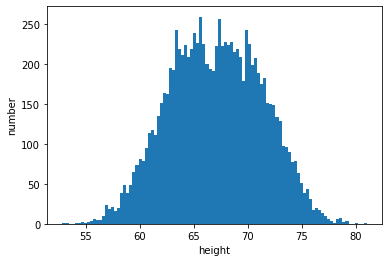

In [5]:
plt.figure()
plt.hist(x, bins=100)
plt.xlabel('height')
plt.ylabel('number')
plt.show()

# Generative model

With a generative model we want to learn the distribution of heights within the female and male classes to make a decision based on Bayes rule.

We will use the knowledge that the distribution within each class is Gaussian. Estimating these distributions then boils down at estimating their means $\mu = (\mu_1, \mu_2)$ and standard deviations $\sigma = (\sigma_1, \sigma_2)$.

In [6]:
mu   = np.array([x[d == k].mean() for k in [0, 1]])
sig  = np.array([x[d == k].std() for k in [0, 1]])

We can use these statistics to define the likelihoods:

$p(x|d=k)=\mathcal{N}(x;\mu_k,\sigma_k)$

where $\mathcal{N}$ is the Gaussian distribution whose implementation is available in scipy. 

In [7]:
lik = lambda x, k : sps.norm(mu[k], sig[k]).pdf(x)

Next we need to estimate the priors $p(d=0)$ and $p(d=0)$, which are simply the frequencies $f = (f_0, f_1)$ of both classes.

In [8]:
freq = np.array([(d == k).mean() for k in [0, 1]])

We can use these statistics to define the joint distributions:

$p(x, d=k) = p(d=k) p(x | d=k)$

In [9]:
joint = lambda x, k : freq[k] * lik(x, k)

We can deduce the marginal density of $x$.

In [10]:
marginal = lambda x : sum(joint(x, l) for l in range(2))

Let us check that all our models fit the distribution of our data

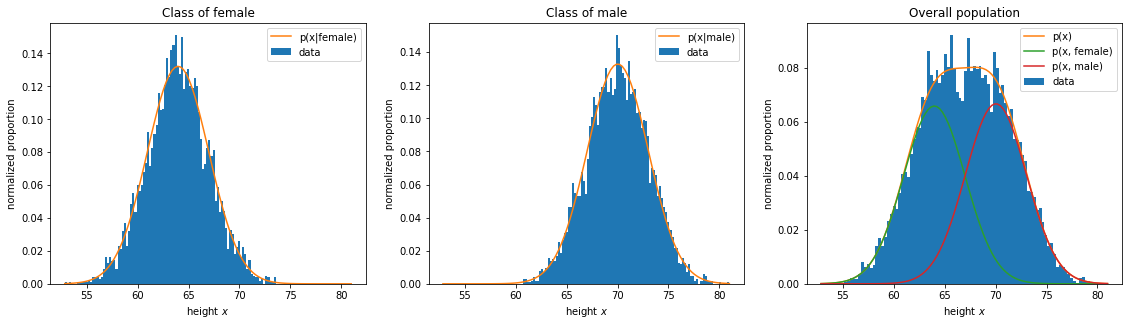

In [11]:
nbins = 100
xgrid = np.linspace(x.min(), x.max(), nbins)
fig, axes = plt.subplots(ncols=3, figsize=[3*6.4, 4.8])
axes[0].hist(x[d == 0], bins=nbins, density=True, label='data')
axes[1].hist(x[d == 1], bins=nbins, density=True, label='data')
axes[2].hist(x, bins=nbins, density=True, label='data')
axes[0].plot(xgrid, lik(xgrid, 0), label='p(x|female)')
axes[1].plot(xgrid, lik(xgrid, 1), label='p(x|male)')
axes[2].plot(xgrid, marginal(xgrid), label='p(x)')
axes[2].plot(xgrid, joint(xgrid, 0), label='p(x, female)')
axes[2].plot(xgrid, joint(xgrid, 1), label='p(x, male)')
for k in range(3):
    axes[k].set_xlabel('height $x$')
    axes[k].set_ylabel('normalized proportion')
    axes[k].legend()
axes[0].set_title('Class of female')
axes[1].set_title('Class of male')
axes[2].set_title('Overall population')
plt.show()

We can deduce the posterior distributions using Bayes rule

$p(d=k|x) = \frac{p(x, d=k)}{p(x)}$

In [12]:
post = lambda x, k : joint(x, k) / marginal(x)

Let us visualize the posterior probabilities as a function of the height $x$.

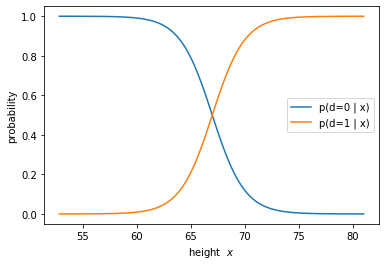

In [13]:
plt.figure()
plt.plot(xgrid, post(xgrid, 0), label='p(d=0 | x)')
plt.plot(xgrid, post(xgrid, 1), label='p(d=1 | x)')
plt.xlabel('height  $x$')
plt.ylabel('probability')
plt.legend()
plt.show()

We can now define our maximum a posterior classifier for $d$

$$
f_{\mathrm{gen}}(x; \theta_{\mathrm{gen}}) = \arg \max_k p_{\theta_{\mathrm{gen}}}(d=k | x) 
$$

where we made explicit the dependency of the posterior with the parameters of our model being:

$$
\theta_{\mathrm{gen}} = (f_1, f_2, \mu_1, \mu_2, \sigma_1, \sigma_2)
\quad\text{ subject to }\quad
f_1 + f_2 = 1
$$


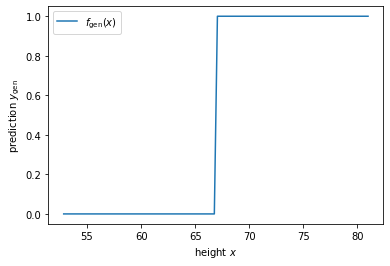

In [14]:
f_gen = lambda x: post(x, 1) > post(x, 0)

plt.figure()
plt.plot(xgrid, f_gen(xgrid), label='$f_{\mathrm{gen}}(x)$')
plt.xlabel('height $x$')
plt.ylabel('prediction $y_{\mathrm{gen}}$')
plt.legend()
plt.show()

Clearly this classifier makes a prediction for $d$ based on a simple thresholding

$$
f_{\rm gen}(x; \theta_{\mathrm{gen}}) = \left\{\begin{array}{ll}
1 & \text{if } x > t\\ 
0 & \text{otherwise}
\end{array}\right.
$$

where $t \approx \tfrac12 (70 + 64) = 67$. In fact $t$ converges in probablity to this value with respect to $N$.

Note that though the loss function is not explicit here, the formulas for the estimation of the models result from optimizing the likelihood of the model parameters on $(x, d)$:

$$
\max_{\theta_{\mathrm{gen}}} \prod_{(x, d) \in \mathcal{T}} p_{\theta_{\mathrm{gen}}}(x, d)
$$


## Discriminative model

In the discriminative approach we do not focus on the distribution of the features. Instead we directly impose a model on the posterior probability. For instance, based on our knowledge that males are in average larger than women, we can choose the following model:

$$
p_t(d=1 | x)  = \left\{\begin{array}{ll}
1 & \text{if } x > t\\ 
0 & \text{otherwise}
\end{array}\right.
$$
and
$$
p_t(d=0 | x) = 1 - p_t(d=1 | x)
$$

The maximum a posteriori classifier is then

$$
f_{\mathrm{dis}}(x; \theta_{\mathrm{dis}} = t) = p_t(d=1 | x)
$$

The parameter $\theta_{\mathrm{dis}}$ of that model is just the threshold.

We will consider the number of errors on the training set as our loss function

$$
\min_{\theta_{\mathrm{dis}}}
\#\{(x, d) \in \mathcal{T} \text{ such that } f_{\mathrm{dis}}(x; \theta_{\mathrm{dis}}) \ne d\}
$$

Clearly this optimization problem can be recasted as

$$
\min_{t}
\underbrace{\#\{(x, d) \in \mathcal{T} \text{ such that } x \le t \text{ and } d = 1\}}_{\text{number of missclassified males}}
+
\underbrace{\#\{(x, d) \in \mathcal{T} \text{ such that } x > t \text{ and } d = 0\}}_{\text{number of missclassified females}}
$$
Or equivalently
$$
\min_{t}
\sum_{(x, d) \in \mathcal{T} ; x \le t}
d
+
\sum_{(x, d) \in \mathcal{T} ; x > t}
1 - d
$$

Now if we denote by $x_k$ the $k$-th smaller individual in $\mathcal{T}$ and $d_k$ its corresponding label, we can show that any solution $t^*$ of the above optimization problem are given by
$$
t^* \in [x_{k^*}, x_{k^*+1}) \quad\text{where}\quad
k^* = \arg \min_{1 \le k \le N-1}
\sum_{i=1}^k d_k
+
\sum_{i=k+1}^N 1 - d_k
$$

which leads us to consider the following code:

In [15]:
idx = np.argsort(x);
sorted_x = x[idx];
sorted_d = d[idx];
nb_missclassified_males = np.cumsum(sorted_d)
nb_missclassified_females = \
    np.sum(1-sorted_d) - np.cumsum(1 - sorted_d)
nb_errors = nb_missclassified_males + nb_missclassified_females 
k = np.argmin(nb_errors)
t_star = (sorted_x[k] + sorted_x[k+1]) / 2

Let us display the loss as a function of $t$. 

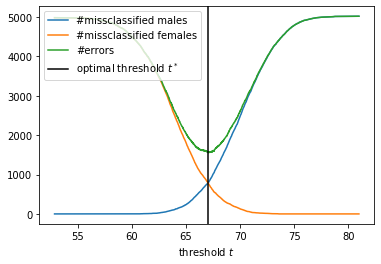

In [16]:
plt.figure()
plt.plot(sorted_x, nb_missclassified_males, \
         label='#missclassified males')
plt.plot(sorted_x, nb_missclassified_females, \
         label='#missclassified females')
plt.plot(sorted_x, nb_errors, label='#errors')
plt.axvline(t_star, color='k', label='optimal threshold $t^*$')
plt.xlabel('threshold $t$')
plt.legend()
plt.show()

We can now define and visualize our classifier.

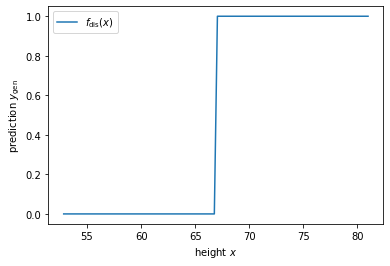

In [17]:
f_dis = lambda x: x > t_star

plt.figure()
plt.plot(xgrid, f_dis(xgrid), label='$f_{\mathrm{dis}}(x)$')
plt.xlabel('height $x$')
plt.ylabel('prediction $y_{\mathrm{gen}}$')
plt.legend()
plt.show()

Note that for such problems, a popular alternative is to model $p(d=1|x)$ with the logisitic function, to consider the cross-entropy loss, and to optimize the parameter with gradient descent, as in Assignment 1.

## Comparisons

Let us compare the two models on a testing set.

In [18]:
Ntest = 1000000
xtest, dtest = simulate_data(Ntest)

In [19]:
ytest = f_gen(xtest)
gen_perf = (ytest == dtest).mean()
print('Success rate of generative model: %.6f' % gen_perf)

Success rate of generative model: 0.841362


In [20]:
ytest = f_dis(xtest)
dis_perf = (ytest == dtest).mean()
print('Success rate of discriminative model: %.6f' % dis_perf)

Success rate of discriminative model: 0.841229


In [21]:
print('Best model is: %s' % \
      ('generative' if gen_perf > dis_perf else 'discriminative'))

Best model is: generative


# Discussion

In this scenario: data in low dimensional space ($x \in \mathbb{R}$), and perfect knowledge on the model of data distribution, the two approaches reach almost the same performance (though the generative seems to be winning more frequently).

This observation will rapidly become invalid as we consider a feature space of larger dimension $x \in \mathbb{R}^d, d \gg 1$ or if the assumed generative model does not fit well the data.

This is because it is easier to model/estimate the shape of a separator than to model/estimate the distribution of each classes, all the more in highdimensional spaces. In this example, estimating the separator requires to estimate one parameter (the threshold $t$), but estimating the class distributions requires to estimate 6 parameters (the means $\mu_k$, standard deviations $\sigma_k$ and frequencies $f_k$). The larger the number of parameters to estimate, the more challenging is the estimation (learning subject to overfitting). Since overfitting is more common in high dimensional feature spaces (curse of dimensionality), generative methods are usually defeated by discriminative ones.